# Load necessary packages

In [81]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
%autoreload 2

In [5]:
# dependencies for this notebook
import os, sys, ee, osmnx as ox

sys.path.insert(0, '../../')
# ee.Initialize()

# prewritten scripts

# utilites
from disaster_preprocessing.code.common import * 
from disaster_preprocessing.code.gdal_tools import *

# data extraction
from disaster_preprocessing.code.extract_data.raster_river import * 
from disaster_preprocessing.code.extract_data.extract_ee import *

# processing scripts
from disaster_preprocessing.code.python_preprocessing.raster_fix import * 
from disaster_preprocessing.code.python_preprocessing.generate_lcm import * 
from disaster_preprocessing.code.python_preprocessing.reprojection import *
from disaster_preprocessing.code.python_preprocessing.pp_raster import *
# from preprocessing.conv_jd import *


In [ ]:
# to reload any modules
import importlib
importlib.reload() 

# Set working folder and create relevant folders

In [6]:
# check what is your working folder, it should be INSIDE the example
os.getcwd()

'/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1'

In [7]:
# set working folders and relevant extensions
working_folder = os.getcwd() + '/'
generated_ext, required_ext = "generated/", "required/"
print(working_folder)

/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/


In [8]:
# create folders for required folder
create_folders(dest = working_folder + required_ext, folders = ['rainfall', 'datafiles', 'geojson', 'convert_files'])

# create folders for generated folder
create_folders(dest = working_folder + generated_ext, folders = [])

Folders [] created
Folders [] created


In [9]:
ctry = 'Indonesia'
gj_file = working_folder + required_ext + f'geojson/{ctry}/Jakarta.geojson'

# Extract Maps from Google Earth

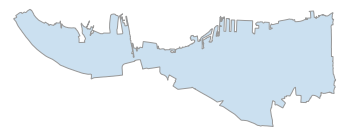

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d5eaef820>)

In [2]:
jkt_gdf = ox.gdf_from_places(['South Jakarta', 'North Jakarta', 'West Jakarta', 'East Jakarta', 'Central Jakarta'])
ox.plot_shape(ox.project_gdf(jkt_gdf))

In [4]:
jkt_gdf.to_file("../data/jkt_shape/epsg4326/indonesia/Indonesia_Jakarta.geojson", driver="GeoJSON")

In [21]:
jkt_gdf = gpd.read_file('../data/jkt_shape/epsg4326/indonesia/Indonesia_Jakarta.geojson')
all_coords = list(zip(*jkt_gdf.geometry[0].exterior.coords.xy))

In [24]:
OUTPUT_BUCKET = '/content/drive/My Drive/Capstone'
aoi = ee.Geometry.Polygon([all_coords])
VECTORIZATION_SCALE = 30

In [82]:
# ESA GLOBCOVER for Landcover
image = ee.Image('ESA/GLOBCOVER_L4_200901_200912_V2_3').clip(aoi)
lcm = image.select(['landcover'])

lcm_export_task = ee.batch.Export.image.toDrive(**{
  'image': lcm,
  'description': 'landcover',
  'scale': 30,
  'fileFormat': 'GeoTIFF',
  'folder': OUTPUT_BUCKET,
  'region': aoi,
  'formatOptions': {
    'cloudOptimized': True
  }
})

ee.batch.Task.start(lcm_export_task)

In [25]:
# SRTM for DEM
image = ee.Image('USGS/SRTMGL1_003').clip(aoi)
dem = image.select('elevation')

# high resolution DEM
export_task_1 = ee.batch.Export.image.toDrive(**{
  'image': dem,
  'description': 'dem_jakarta_5',
  'scale': 5,
  'folder': OUTPUT_BUCKET,
  'fileFormat': 'GeoTIFF',
  'region': aoi,
  'formatOptions': {
    'cloudOptimized': True
  }
})

# low resolution DEM
export_task_1 = ee.batch.Export.image.toDrive(**{
  'image': dem,
  'description': 'dem_jakarta_30',
  'scale': 30,
  'folder': OUTPUT_BUCKET,
  'fileFormat': 'GeoTIFF',
  'region': aoi,
  'formatOptions': {
    'cloudOptimized': True
  }
})

ee.batch.Task.start(export_task)

In [29]:
tasks = ee.batch.Task.list()
tasks

[<Task EXPORT_IMAGE: dem_jakarta_5 (RUNNING)>,
 <Task EXPORT_IMAGE: dem_jakarta_1 (FAILED)>,
 <Task EXPORT_IMAGE: dem_jakarta_20 (COMPLETED)>,
 <Task EXPORT_IMAGE: dem_jakarta_20 (FAILED)>,
 <Task EXPORT_IMAGE: dem_jakarta_20 (COMPLETED)>,
 <Task EXPORT_IMAGE: dem_jkt_gmted (COMPLETED)>,
 <Task EXPORT_IMAGE: dem_jkt_gmted (COMPLETED)>,
 <Task EXPORT_IMAGE: dem_jkt_gmted (COMPLETED)>]

# Map Landcover Parameters into Landcover Maps

In [12]:
category = read_category(working_folder + required_ext + "convert_files/mapping.json")
data_conv_dict, trans_dict = convert_params(working_folder + required_ext + "convert_files/params.csv")

src_file = working_folder + required_ext + 'datafiles/landcover.tif'
dst_folder = working_folder + generated_ext + 'base_maps/'

meta, all_info_cat = do_preprocessing(src_file, category, data_conv_dict, trans_dict)
gdf, d_types, crs = process_df(all_info_cat, src_file)

for k,v in d_types.items():
    if k in gdf.columns.tolist():
        
        meta = update_meta(meta, crs, dtype = 'float32')

        dest_file = f'{dst_folder}{k}.tif'
        write_gdf_to_raster_rio(data = gdf, selector = k, dest_file = dest_file, meta = meta)
    

---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/landcover.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox(left=106.68536044648896, bottom=-6.374624919168948, right=106.97398914727655, top=-6.08896065881894)
SIZE: (1135260,)
0.0
94.33962264150944
0.0
94.33962264150944
Successfully generated metadata and category mapping for all files!
0.0
47.16981132075472
94.33962264150944
landunits
Minimum Dtype for landunits : uint8
n
Minimum Dtype for n : float32
rr
Minimum Dtype for rr : float32
per
Minimum Dtype for per : float32
ch
Minimum Dtype for ch : float32
lai
Minimum Dtype for lai : float32
ksat1
Minimum Dtype for ksat1

In [26]:
# get the working folder and resulting files for base_maps
folder, files = get_folder_files('', '', dest = working_folder + generated_ext + 'base_maps/')
folder, files

/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/ ['thetas1.tif', 'rr.tif', 'landunits.tif', 'ch.tif', 'n.tif', 'per.tif', 'lai.tif', 'ksat1.tif', 'psi1.tif', 'dem.tif', 'thetai1.tif']
Data Name thetas1.tif, Data Rows: 1060, Data Columns: 1071
Data Name rr.tif, Data Rows: 1060, Data Columns: 1071
Data Name landunits.tif, Data Rows: 1060, Data Columns: 1071
Data Name ch.tif, Data Rows: 1060, Data Columns: 1071
Data Name n.tif, Data Rows: 1060, Data Columns: 1071
Data Name per.tif, Data Rows: 1060, Data Columns: 1071
Data Name lai.tif, Data Rows: 1060, Data Columns: 1071
Data Name ksat1.tif, Data Rows: 1060, Data Columns: 1071
Data Name psi1.tif, Data Rows: 1060, Data Columns: 1071
Data Name dem.tif, Data Rows: 1059, Data Columns: 1071
Data Name thetai1.tif, Data Rows: 1060, Data Columns: 1071


('/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/',
 ['thetas1.tif',
  'rr.tif',
  'landunits.tif',
  'ch.tif',
  'n.tif',
  'per.tif',
  'lai.tif',
  'ksat1.tif',
  'psi1.tif',
  'dem.tif',
  'thetai1.tif'])

# Cut map data into correct shape

In [10]:
ctry = "Indonesia"
gj_file = working_folder + required_ext + f'geojson/{ctry}_NorthJakarta.geojson'


In [11]:
folder, files = get_folder_files('', '','.tif',  dest = working_folder + generated_ext + 'base_maps/')
files = rearrange_dem(files)
files

/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/ ['thetas1.tif', 'rr.tif', 'landunits.tif', 'ch.tif', 'n.tif', 'per.tif', 'lai.tif', 'ksat1.tif', 'psi1.tif', 'dem.tif', 'thetai1.tif']
Data Name thetas1.tif, Data Rows: 1060, Data Columns: 1071
Data Name rr.tif, Data Rows: 1060, Data Columns: 1071
Data Name landunits.tif, Data Rows: 1060, Data Columns: 1071
Data Name ch.tif, Data Rows: 1060, Data Columns: 1071
Data Name n.tif, Data Rows: 1060, Data Columns: 1071
Data Name per.tif, Data Rows: 1060, Data Columns: 1071
Data Name lai.tif, Data Rows: 1060, Data Columns: 1071
Data Name ksat1.tif, Data Rows: 1060, Data Columns: 1071
Data Name psi1.tif, Data Rows: 1060, Data Columns: 1071
Data Name dem.tif, Data Rows: 1059, Data Columns: 1071
Data Name thetai1.tif, Data Rows: 1060, Data Columns: 1071


['dem.tif',
 'thetas1.tif',
 'rr.tif',
 'landunits.tif',
 'ch.tif',
 'n.tif',
 'per.tif',
 'lai.tif',
 'ksat1.tif',
 'psi1.tif',
 'dem.tif',
 'thetai1.tif']

In [29]:
dest_folder = 'fixed_raster/'

open_and_clip_datasets(folder = folder, files = files, working_folder = working_folder + generated_ext, \
                       dest_folder = dest_folder, gjson = gj_file)


----------- PROCESSING -----------
DEST FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/thetas1.tif
FILE TITLE:  thetas1
SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/thetas1.tif
DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/thetas1.tif
DEM SHAPE: (106

DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/rr.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox(l

Wrote file /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/landunits.tif to /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/landunits.tif
----------- PROCESSING -----------
DEST FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/ch.tif
FILE TITLE:  ch
SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/ch.tif
DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCC

DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/n.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox(le

Wrote file /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/per.tif to /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/per.tif
----------- PROCESSING -----------
DEST FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/lai.tif
FILE TITLE:  lai
SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/lai.tif
DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966


COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/lai.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox(left=106.68536044648896, bottom=-6.374624919168948, right=106.97398914727655, top=-6.08896065881894)
SIZE: (1135260,)
---- WRITING TO DESTINATION FILE ----
WRITING FILE FOR: lai
DATA DIMENSION: 348 964
DATA DIMENSION OF ARRAY TO WRITE: (348, 964)
WRITING TO DESTINATION FILE: /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/e

DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/ksat1.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBo

DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/psi1.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox

DEM SOURCE FILE:  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/dem.tif
DEM DIMENSIONS:  348 964
SOURCE FILE DIMENSIONS:  350 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  349 966
ROW MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER ROW MODIFICATIONS:  348 966
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 965
COLUMN MODIFICATION OCCURED FOR FILE. DIMENSIONS AFTER COLUMN MODIFICATIONS:  348 964
---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/base_maps/thetai1.tif
DEM SHAPE: (1060, 1071)
METADATA: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1071, 'height': 1060, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 106.68536044648896,
       0.0, -0.0002694945852358564, -6.08896065881894)}
FILE CRS: EPSG:4326
FILE BOUNDS: Bounding

In [111]:
folder = working_folder + generated_ext + 'fixed_raster/'

folder

'/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/'

# Generate River and Building Data

In [118]:
generate_res_data(folder = working_folder, \
                          ref_file = working_folder + extensions['required'] + 'datafiles/' + "modified_dem/dem_hi_res.tif", \
                  map_type = 'building', folder_ext = extensions['generated'])

File does not exist
SHAPE FILE REFERENCE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/building/building.shp
DESTINATION FILE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building_hi_res.tif
REFERENCE IMAGE FILE: /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/modified_dem/dem_hi_res.tif
Rasterising shapefile...
NO DATA VALUE None
Done.
SUCCESFULLY RASTERED building TO .TIF FILE AT /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building_hi_res.tif USING /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/modified_dem/dem_hi_res.tif


In [112]:
maps_for_generation = ["river", "building"]

extensions = {"generated":generated_ext, "required":required_ext}

generate_maps(working_folder = working_folder, folder = folder, map_iter = maps_for_generation, ext = extensions)


HIGH RES DEM FOLDER /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/
********** GENERATING CORRECTION LAYER FOR river **********
 ---- GENERATING HIGH RES DATA ----
File does not exist
SHAPE FILE REFERENCE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/river/river.shp
DESTINATION FILE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/chanmask_hi_res.tif
REFERENCE IMAGE FILE: /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/modified_dem/dem_hi_res.tif
Rasterising shapefile...
NO DATA VALUE None


Done.
SUCCESFULLY RASTERED river TO .TIF FILE AT /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/chanmask_hi_res.tif USING /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/modified_dem/dem_hi_res.tif
 ---- GENERATING LOW RES DATA ----
File does not exist
SHAPE FILE REFERENCE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/river/river.shp
DESTINATION FILE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/chanmask.tif
REFERENCE IMAGE FILE: /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/rr.tif
Rasterising shapefile...
NO DATA VALUE None
Done.
SUCCESFULLY RASTERED river TO .TIF FILE AT /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/chanmask.tif USING /Users/tinkertanker/Documen

3it [00:00, 26.15it/s]

---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/chanmask_hi_res.tif
DEM SHAPE: (2093, 5791)
METADATA: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0001, 'width': 5791, 'height': 2093, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.491576420597607e-05, 0.0, 106.68555085492704,
       0.0, -4.491576420597607e-05, -6.089141142605335)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox(left=106.68555085492704, bottom=-6.183149837088443, right=106.94565804544385, top=-6.089141142605335)
SIZE: (12120563,)
SIZE OF NON ZERO CELLS (HIGH RES BUILDING DATA): 56041
HIGH RESOLUTION GRID SIZE 12120563
META 1: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0001, 'width': 5791, 'height': 2093, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.491576420597607e-05, 0.0, 106.68555085492704,
       0.0, -4.491576420597607e-05, -6.089141142605335), 'compress': 'lzw'}
META 2: {'d

348it [00:15, 23.08it/s]
../../disaster_preprocessing/code/extract_data/raster_river.py:316: RuntimeWarning: invalid value encountered in greater
  total_corrected += len(data_arr[data_arr>0])
46it [00:00, 455.81it/s]

TOTAL COUNTED GRIDS: 12076992
ORIGINAL NUMBER OF POINTS: 8860
CORRECTED NUMBER OF POINTS: 129609
PERCENTAGE OF POINTS CORRECTED: 1362.856 %


348it [00:02, 150.41it/s]


                     geometry  data
0  POINT (106.50000 -6.00000)   0.0
1  POINT (106.50027 -6.00000)   0.0
2  POINT (106.50054 -6.00000)   0.0
3  POINT (106.50081 -6.00000)   0.0
4  POINT (106.50108 -6.00000)   0.0
---- WRITING TO DESTINATION FILE ----
WRITING FILE FOR:  data
DATA DIMENSION: 348 964
WROTE FILE FOR ITEM river TO /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/river_2.tif
********** GENERATING CORRECTION LAYER FOR building **********
 ---- GENERATING HIGH RES DATA ----
File does not exist
SHAPE FILE REFERENCE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/building/building.shp
DESTINATION FILE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building_hi_res.tif
REFERENCE IMAGE FILE: /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/modified_dem/dem_hi_res.tif
Rasterisi

Done.
SUCCESFULLY RASTERED building TO .TIF FILE AT /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building_hi_res.tif USING /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/required/datafiles/modified_dem/dem_hi_res.tif
 ---- GENERATING LOW RES DATA ----
File does not exist
SHAPE FILE REFERENCE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/building/building.shp
DESTINATION FILE /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building.tif
REFERENCE IMAGE FILE: /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/rr.tif
Rasterising shapefile...
NO DATA VALUE None
Done.
SUCCESFULLY RASTERED building TO .TIF FILE AT /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building.tif USING /Users/tinkerta

2it [00:00, 19.68it/s]

---- OPENING SOURCE FILE ----
FILENAME,  /Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/fixed_raster/building_hi_res.tif
DEM SHAPE: (2093, 5791)
METADATA: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0001, 'width': 5791, 'height': 2093, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.491576420597607e-05, 0.0, 106.68555085492704,
       0.0, -4.491576420597607e-05, -6.089141142605335)}
FILE CRS: EPSG:4326
FILE BOUNDS: BoundingBox(left=106.68555085492704, bottom=-6.183149837088443, right=106.94565804544385, top=-6.089141142605335)
SIZE: (12120563,)
SIZE OF NON ZERO CELLS (HIGH RES BUILDING DATA): 0
HIGH RESOLUTION GRID SIZE 12120563
META 1: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0001, 'width': 5791, 'height': 2093, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.491576420597607e-05, 0.0, 106.68555085492704,
       0.0, -4.491576420597607e-05, -6.089141142605335), 'compress': 'lzw'}
META 2: {'drive

348it [00:18, 19.24it/s]

TOTAL COUNTED GRIDS: 12076992



../../disaster_preprocessing/code/extract_data/raster_river.py:316: RuntimeWarning: invalid value encountered in greater
  total_corrected += len(data_arr[data_arr>0])


ZeroDivisionError: division by zero

In [108]:
xds, crs, nodata, bounds, width, height, transform = get_meta(working_folder + generated_ext + "fixed_raster/", 'dem.tif')
xds, crs, nodata, bounds, width, height, transform

(<xarray.DataArray (band: 1, y: 348, x: 964)>
 dask.array<open_rasterio-172983802c36b886e1b89c2730cf0621<this-array>, shape=(1, 348, 964), dtype=float32, chunksize=(1, 348, 964), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 1
   * y            (y) float64 -6.0 -6.0 -6.001 -6.001 ... -6.093 -6.094 -6.094
   * x            (x) float64 106.5 106.5 106.5 106.5 ... 106.8 106.8 106.8 106.8
     spatial_ref  int64 0
 Attributes:
     transform:     (0.00026994924954108627, 0.0, 106.5, 0.0, -0.0002699492495...
     _FillValue:    0.0001
     scale_factor:  1.0
     add_offset:    0.0
     grid_mapping:  spatial_ref,
 CRS.from_epsg(4326),
 0.0001,
 (106.5, -6.093942338840297, 106.7602310765576, -6.0),
 964,
 348,
 Affine(0.00026994924954108627, 0.0, 106.5,
        0.0, -0.00026994924954108627, -6.0))

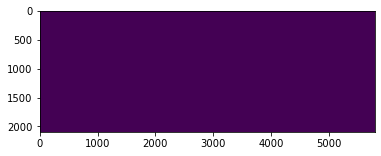

In [120]:
show_sample(working_folder+generated_ext+"fixed_raster/building_hi_res.tif")

In [ ]:
show_sample(folder+"building_2.tif")

Dataset plotted:  dem.tif


/Users/tinkertanker/anaconda3/envs/palantir/lib/python3.8/site-packages/earthpy/spatial.py:560: RuntimeWarning: invalid value encountered in greater
  data[data > cmax] = cmax


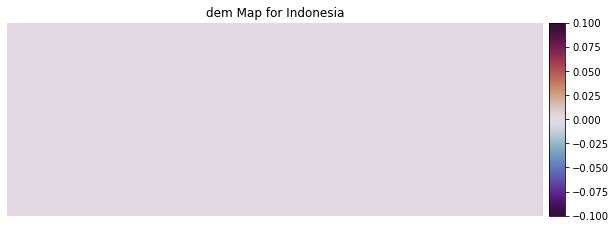

Dataset plotted:  thetas1.tif


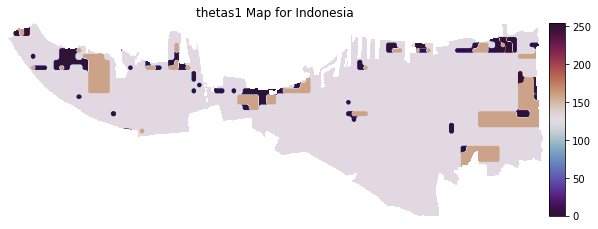

Dataset plotted:  rr.tif


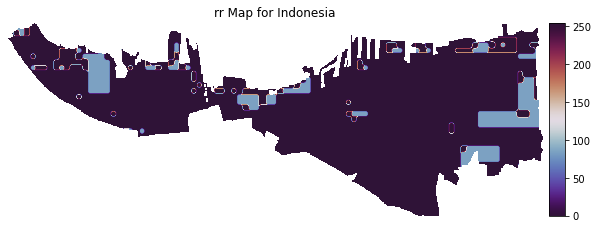

Dataset plotted:  landunits.tif


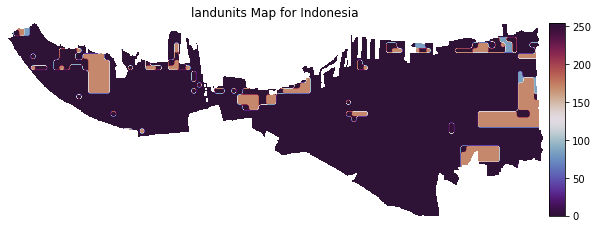

Dataset plotted:  chanmask.tif
Cmax and Cmin value error for dataset:  chanmask.tif
Dataset plotted:  chanmask_3.tif


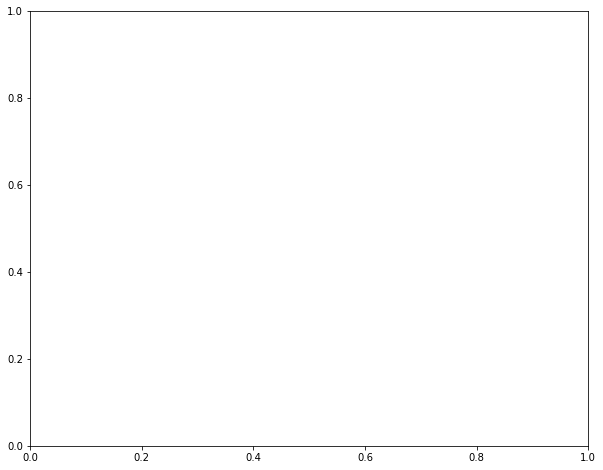

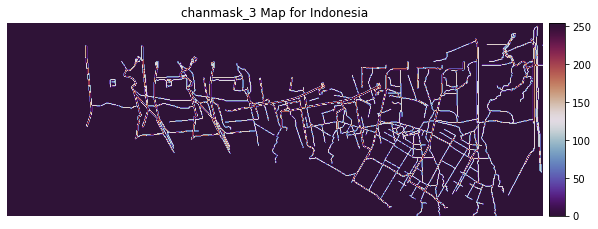

Dataset plotted:  buildings_2.tif


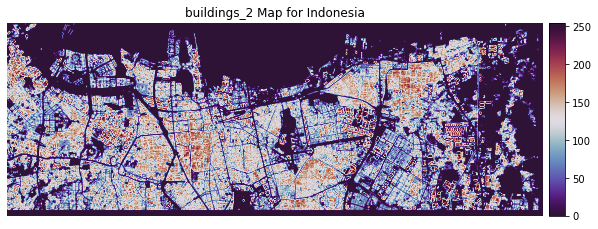

Dataset plotted:  ch.tif


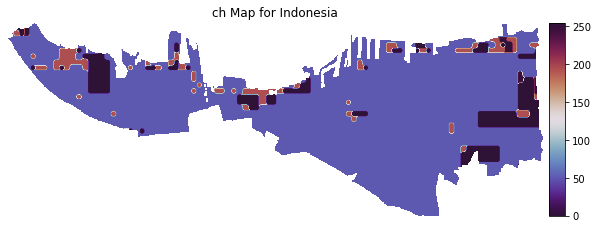

Dataset plotted:  buildings.tif
Cmax and Cmin value error for dataset:  buildings.tif
Dataset plotted:  n.tif


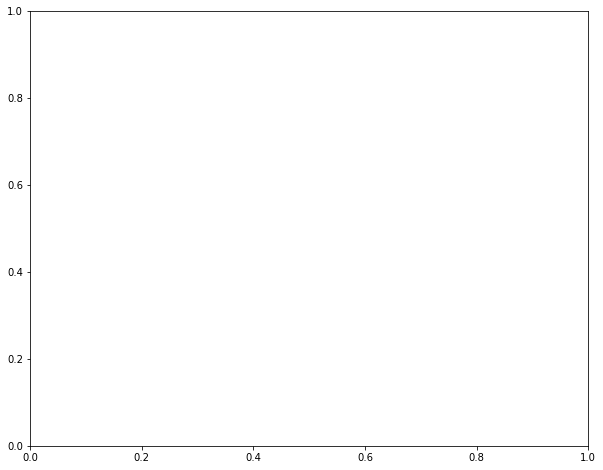

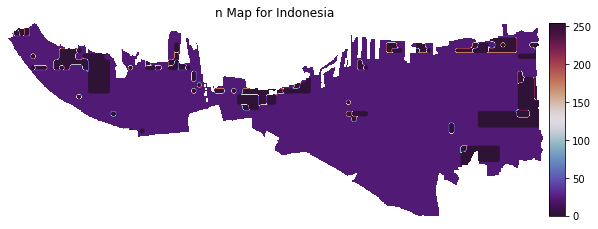

Dataset plotted:  per.tif


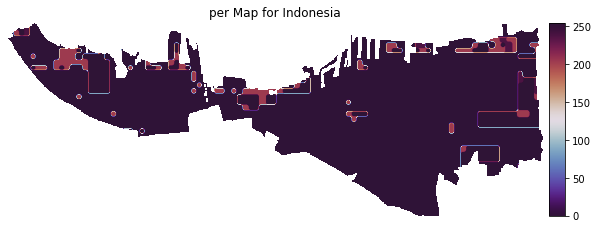

Dataset plotted:  lai.tif


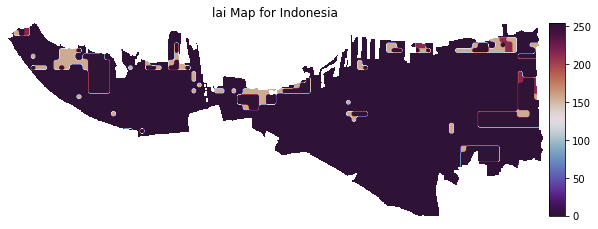

Dataset plotted:  ksat1.tif


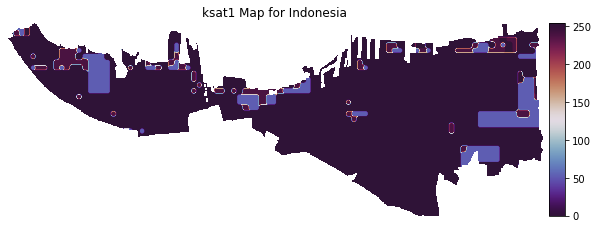

Dataset plotted:  psi1.tif


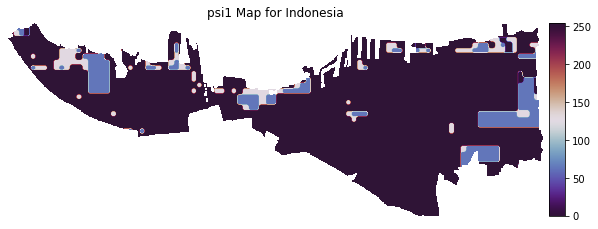

Dataset plotted:  dem.tif


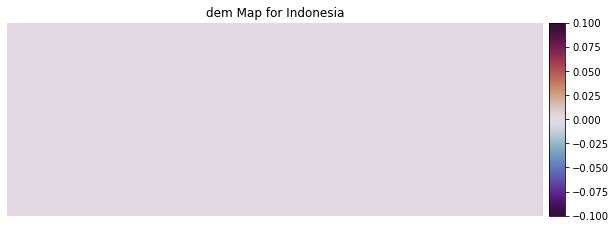

Dataset plotted:  thetai1.tif


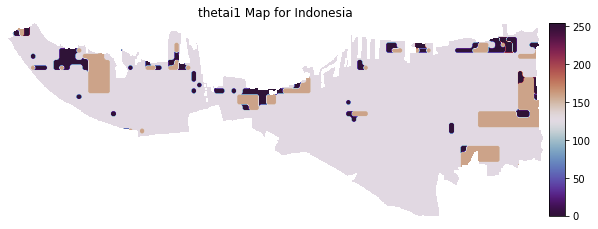

('../data/experiments/jakarta/exp16/fixed_raster/',
 ['dem.tif',
  'thetas1.tif',
  'rr.tif',
  'landunits.tif',
  'chanmask.tif',
  'chanmask_3.tif',
  'buildings_2.tif',
  'ch.tif',
  'buildings.tif',
  'n.tif',
  'per.tif',
  'lai.tif',
  'ksat1.tif',
  'psi1.tif',
  'dem.tif',
  'thetai1.tif',
  'mask.tif'])

In [165]:
open_and_plot_datasets(folder, files)
files.append('mask.tif')
folder, files

# Reproject the maps into a Mercator Format

In [86]:
nodata = -3.4028234663852886e+38
run_processing(folder=folder, working_folder=working_folder, dest_folder='reprojection/', target_crs=900913, \
               files=files, nodata=nodata)


9it [00:00, 87.07it/s]

Map name: dem
src_file: ../data/experiments/jakarta/exp16/fixed_raster/dem.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/dem.tif
File at ../data/experiments/jakarta/exp16/reprojection/dem.tif exists!
Map name: thetas1
src_file: ../data/experiments/jakarta/exp16/fixed_raster/thetas1.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/thetas1.tif
File at ../data/experiments/jakarta/exp16/reprojection/thetas1.tif exists!
Map name: rr
src_file: ../data/experiments/jakarta/exp16/fixed_raster/rr.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/rr.tif
File at ../data/experiments/jakarta/exp16/reprojection/rr.tif exists!
Map name: landunits
src_file: ../data/experiments/jakarta/exp16/fixed_raster/landunits.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/landunits.tif
File at ../data/experiments/jakarta/exp16/reprojection/landunits.tif exists!
Map name: chanmask
src_file: ../data/experiments/jakarta/exp16/fixed_ras

348it [00:04, 72.63it/s]
44it [00:00, 436.53it/s]

AFTER COL MODIFICATIONS:  966


350it [00:02, 118.18it/s]


(338100, 2)
---- WRITING TO DESTINATION FILE ----
WRITING FILE FOR:  chanmask
DATA DIMENSION: 350 966
Map name: ch
src_file: ../data/experiments/jakarta/exp16/fixed_raster/ch.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/ch.tif
File at ../data/experiments/jakarta/exp16/reprojection/ch.tif exists!
Map name: buildings
src_file: ../data/experiments/jakarta/exp16/fixed_raster/buildings.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/buildings.tif
File at ../data/experiments/jakarta/exp16/reprojection/buildings.tif exists!
Map name: n
src_file: ../data/experiments/jakarta/exp16/fixed_raster/n.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/n.tif
File at ../data/experiments/jakarta/exp16/reprojection/n.tif exists!
Map name: per
src_file: ../data/experiments/jakarta/exp16/fixed_raster/per.tif
destination file: ../data/experiments/jakarta/exp16/reprojection/per.tif
File at ../data/experiments/jakarta/exp16/reprojection/per.tif ex

In [72]:
folder, files = get_folder_files('', '', '.tif', dest=working_folder+generated_ext+'reprojection/')
folder, files


/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/reprojection/ ['thetas1.tif', 'rr.tif', 'landunits.tif', 'chanmask.tif', 'ch.tif', 'buildings.tif', 'n.tif', 'per.tif', 'mask.tif', 'lai.tif', 'ksat1.tif', 'psi1.tif', 'dem.tif', 'thetai1.tif']
Data Name thetas1.tif, Data Rows: 350, Data Columns: 966
Data Name rr.tif, Data Rows: 350, Data Columns: 966
Data Name landunits.tif, Data Rows: 350, Data Columns: 966
Data Name chanmask.tif, Data Rows: 350, Data Columns: 966
Data Name ch.tif, Data Rows: 350, Data Columns: 966
Data Name buildings.tif, Data Rows: 350, Data Columns: 966
Data Name n.tif, Data Rows: 350, Data Columns: 966
Data Name per.tif, Data Rows: 350, Data Columns: 966
Data Name mask.tif, Data Rows: 350, Data Columns: 966
Data Name lai.tif, Data Rows: 350, Data Columns: 966
Data Name ksat1.tif, Data Rows: 350, Data Columns: 966
Data Name psi1.tif, Data Rows: 350, Data Columns: 966
Data Name dem.tif, Data Rows: 350, Data Columns: 966
Data 

('/Users/tinkertanker/Documents/ESD/capstone/code/disaster_preprocessing/example_1/generated/reprojection/',
 ['thetas1.tif',
  'rr.tif',
  'landunits.tif',
  'chanmask.tif',
  'ch.tif',
  'buildings.tif',
  'n.tif',
  'per.tif',
  'mask.tif',
  'lai.tif',
  'ksat1.tif',
  'psi1.tif',
  'dem.tif',
  'thetai1.tif'])

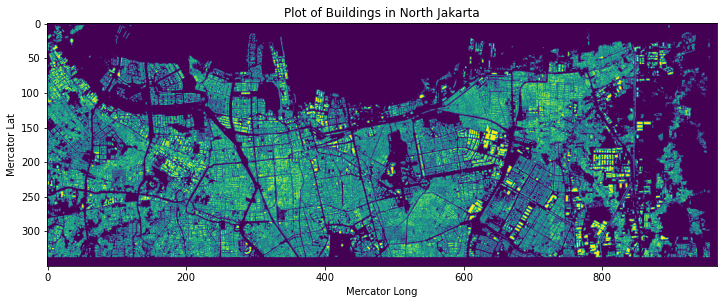

In [80]:
get_meta(folder, 'buildings.tif')
# open_and_plot_datasets(folder, files)
fig = plt.figure(figsize=(12,8))
plt.title("Plot of Buildings in North Jakarta")
plt.xlabel('Mercator Long')
plt.ylabel('Mercator Lat')
show_sample(folder+"buildings.tif")

# Convert to .map

In [95]:
folder, files = get_folder_files('', '', '.tif', dest=working_folder+'reprojection/')
folder, files


../data/sample/generated/reprojection/ ['thetas1.tif', 'rr.tif', 'landunits.tif', 'chanmask.tif', 'buildings_2.tif', 'ch.tif', 'n.tif', 'per.tif', 'mask.tif', 'lai.tif', 'donotuse_IGNORE.tif', 'ksat1.tif', 'psi1.tif', 'dem.tif', 'thetai1.tif']
Data Name thetas1.tif, Data Rows: 350, Data Columns: 966
Data Name rr.tif, Data Rows: 350, Data Columns: 966
Data Name landunits.tif, Data Rows: 350, Data Columns: 966
Data Name chanmask.tif, Data Rows: 350, Data Columns: 966
Data Name buildings_2.tif, Data Rows: 350, Data Columns: 966
Data Name ch.tif, Data Rows: 350, Data Columns: 966
Data Name n.tif, Data Rows: 350, Data Columns: 966
Data Name per.tif, Data Rows: 350, Data Columns: 966
Data Name mask.tif, Data Rows: 350, Data Columns: 966
Data Name lai.tif, Data Rows: 350, Data Columns: 966
Data Name donotuse_IGNORE.tif, Data Rows: 350, Data Columns: 966
Data Name ksat1.tif, Data Rows: 350, Data Columns: 966
Data Name psi1.tif, Data Rows: 350, Data Columns: 966
Data Name dem.tif, Data Rows: 35

('../data/sample/generated/reprojection/',
 ['thetas1.tif',
  'rr.tif',
  'landunits.tif',
  'chanmask.tif',
  'buildings_2.tif',
  'ch.tif',
  'n.tif',
  'per.tif',
  'mask.tif',
  'lai.tif',
  'donotuse_IGNORE.tif',
  'ksat1.tif',
  'psi1.tif',
  'dem.tif',
  'thetai1.tif'])

In [96]:
dest_folder = folder[:folder.find('/reprojection')] + '/maps/'
dest_folder

'../data/sample/generated/maps/'

In [97]:
curr_folder = set_current_folder()
curr_folder

'/Users/tinkertanker/Documents/ESD/capstone/code'

In [98]:
gdal_trans(folder, files, dest_folder, curr_folder=curr_folder)

/Users/tinkertanker/Documents/ESD/capstone/data/sample/generated/reprojection
DATASET:  thetas1
gdal_translate -ot Float32 -of PCRaster -mo PCRASTER_VALUESCALE=VS_SCALAR thetas1.tif thetas1.map
successfully converted thetas1 to map file at thetas1.map
DATASET:  rr
gdal_translate -ot Float32 -of PCRaster -mo PCRASTER_VALUESCALE=VS_SCALAR rr.tif rr.map
successfully converted rr to map file at rr.map
DATASET:  landunits
gdal_translate -ot Float32 -of PCRaster -mo PCRASTER_VALUESCALE=VS_SCALAR landunits.tif landunits.map
successfully converted landunits to map file at landunits.map
DATASET:  chanmask
gdal_translate -ot Float32 -of PCRaster -mo PCRASTER_VALUESCALE=VS_SCALAR chanmask.tif chanmask.map
successfully converted chanmask to map file at chanmask.map
DATASET:  buildings_2
gdal_translate -ot Float32 -of PCRaster -mo PCRASTER_VALUESCALE=VS_SCALAR buildings_2.tif buildings_2.map
successfully converted buildings_2 to map file at buildings_2.map
DATASET:  ch
gdal_translate -ot Float32 -o

In [99]:
folder, files = get_folder_files('', '.aux', '.map', dest=working_folder+'maps/')
files

../data/sample/generated/maps/ ['per.map', 'mask.map', 'lai.map', 'donotuse_IGNORE.map', 'ksat1.map', 'psi1.map', 'thetai1.map', 'dem.map', 'thetas1.map', 'rr.map', 'landunits.map', 'chanmask.map', 'buildings_2.map', 'ch.map', 'n.map']


['per.map',
 'mask.map',
 'lai.map',
 'donotuse_IGNORE.map',
 'ksat1.map',
 'psi1.map',
 'thetai1.map',
 'dem.map',
 'thetas1.map',
 'rr.map',
 'landunits.map',
 'chanmask.map',
 'buildings_2.map',
 'ch.map',
 'n.map']

In [100]:
chg_to_folder(folder)
dem, n, lai, rr, ch, per, thetas1, thetai1, ksat1, landunit, mask, psi1, chanmask = read_maps()
create_catchment(dem, n, lai, rr, ch, per, thetas1, thetai1, ksat1, landunit, mask, psi1, chanmask)
set_chan_properties(mask, chanmask, dem)
soil_surface(mask, ksat1, thetas1, thetai1, psi1)
chg_to_folder(curr_folder)

/Users/tinkertanker/Documents/ESD/capstone/data/sample/generated/maps
Reporting maps
Created maps
/Users/tinkertanker/Documents/ESD/capstone/code


In [128]:
os.chdir('../../../../../code')
os.getcwd()

'/Users/tinkertanker/Documents/ESD/capstone/code'

In [101]:
return_msgs = get_gdal_info(files, folder, curr_folder)

/Users/tinkertanker/Documents/ESD/capstone/data/sample/generated/maps
/Users/tinkertanker/Documents/ESD/capstone/code


In [102]:
df = extract_gdal_meta(return_msgs)
df['name'] = df['name'].apply(lambda x: x.strip())

In [103]:
df

,name,size,origin,pixel size,upper left,lower left,upper right,lower right,center,block,min_max,nodata
0,per,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,0.100 0.850,-3.4028234663852886e+38
1,mask,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,1.000 1.000,-3.4028234663852886e+38
2,lai,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,0.263 4.740,-3.4028234663852886e+38
3,donotuse_ignore,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,1.000 1.000,-3.4028234663852886e+38
4,ksat1,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,28.000 158.430,-3.4028234663852886e+38
5,psi1,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,40.000 50.000,-3.4028234663852886e+38
6,thetai1,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,0.448 0.512,-3.4028234663852886e+38
7,dem,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,-4.024 33.694,-3.4028234663852886e+38
8,thetas1,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -679099.478 106d56'45.12""e ...","11905159.329 -689606.481 106d56'45.12""e ...",11890659.664 -684352.979 106d48'56.2...,band 1 966x1 type float32 colorinterp gray,0.560 0.640,-3.4028234663852886e+38
9,rr,966 350,11876160.000000000000000 -679099.477651000...,30.020009000000002 -30.020009000000002,"11876160.000 -679099.478 106d41' 7.30""e ...","11876160.000 -689606.481 106d41' 7.30""e ...","11905159.329 -67909